# 第8章　自然言語処理（感情分析）

[［第2版］Python機械学習プログラミング 達人データサイエンティストによる理論と実践](https://book.impress.co.jp/books/1117101099)

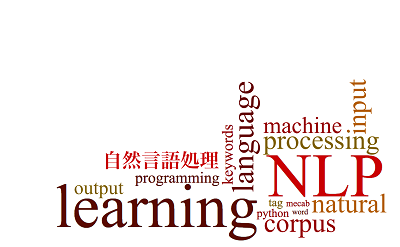

## 8.0　自然言語処理とは

Q1. 突然ですが、問題です・・・

・**いぬがねこをうんだよ**

これは、どういう意味か分かりますか？

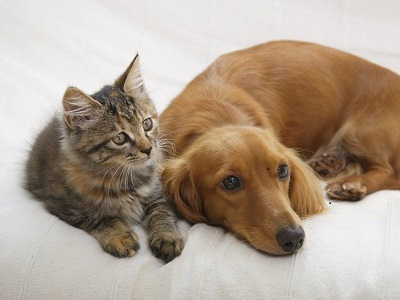

ここで、漢字に直してみると・・・

①犬が猫を産んだよ<br>
②犬がね、子を産んだよ<br>

となり、当然②が正解だなと分かります。

私たち人間であれば、この程度の文章は理解できますが<br>
我々が扱うコンピューターでは、そう簡単に認識してくれません。<br>
（0や1などの数字だけを認識します）<br>

今回はコンピューターに文章を理解させるところから<br>
その文章の中で、特に大事なキーワードは何なのかなどを判定させるための<br>
プログラムを作成していきます。

ちなみに数字ではなく、上記のような言葉や文章を**自然言語**といいます。

次に、下記の小説を用意します。

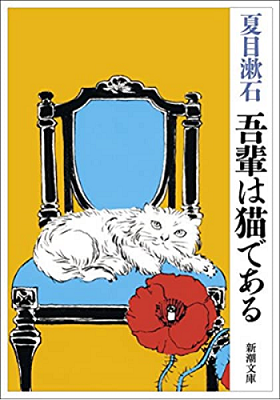

中身の文章を見てみます。

Q2. 1冊の小説の中で、圧倒的に頻度の多いキーワードがあります。<br>
　　さて、何でしょうか？

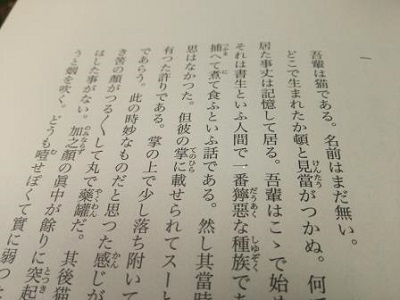

A2. おそらく「猫」である可能性が高いでしょう。<br>
このように、頻度が多かったり、重要な単語やキーワードを**特徴語**といいます。

そして特徴語はもちろん、複数存在します。

（例）猫、草、空、海　など

このとき、機械学習ではそれぞれのキーワードの頻度を計算して<br>
それに従って最も重要なキーワード、次に重要なキーワードなどと「重み」決めていきます。<br>

今の内容を少し専門的に表現すると、下記になります。<br>

**形態素解析**：品詞ごとに区切っているもの<br>
**Bag of Words**：各単語の頻出度を数字化しているもの

ここで面白いのは、夏目漱石の全小説の文章を学習させてモデルを作る。<br>
（例えばみなさんも、全部読んだ後に何かしらの小説を読んだら、それが漱石かどうかでないかの区別はできるかと思います）

そうなった状態で、次の小説の文を投入してみます。<br>

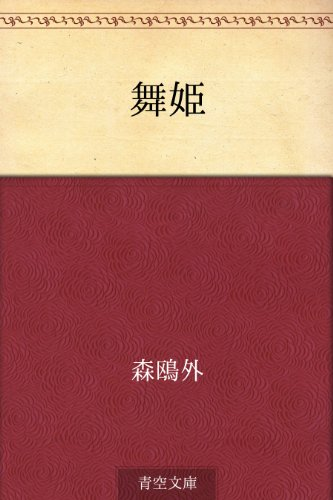

<br>
漱石の小説のみ学習していたら　→「これは夏目漱石の小説ではありません」と返ってくると思いますし<br>
もし、森鴎外の小説も学習していたら　→「この小説を書いたのは・・・森鴎外です」となるかもしれません。

今回は映画レビューのデータセットを読み込んで<br>
肯定的なレビュー（面白かった など）と否定的なレビュー（つまらなかった など）に分けていきます。

これを**極性判定**といいます。

<br>

## 8.0.5　自然言語処理の6ステップ<br>

下記手順に沿って進めていきます。

#### ①自然言語（文章）を用意

　吾輩は猫である。

#### ②単語ごとに区切る（形態素解析）

　吾輩　／　は　／　猫　／　で　／　ある　／　。<br>

#### ③助詞「「てにをは」などを削除する（データのクレンジング）

　吾輩　／　猫　　　※それ以外は削除<br>

#### ④単語を原形（running→run など）に戻す（トークン化）

　今回はなし<br>

#### ⑤各語句の頻出度を求める（BoW）

　吾輩：１　猫：1<br>
  

#### ⑥各語句の重み（TF-IDF）を調べ、特徴語を決める

　吾輩：xxx　、猫：xxxx　　　→　特徴語は「猫」<br>

#### ⑦他の文章との区別（分類）を行う（ロジスティック回帰）

　夏目漱石「吾輩は猫である」の特徴語：猫　、　森鴎外「舞姫」の特徴語：姫

　どちらかの小説の一文を投入する　→　この小説は「夏目漱石」の小説です

<br>
以上が自然言語処理の流れとなります。

ただし、教科書では各ステップが順番通りでの記載となっていないので、注意が必要です。

## 8.1　IMDbデータセットの取得<br>

[IMDb](http://ai.stanford.edu/~amaas/data/sentiment/)：映画レビューのデータセット

In [1]:
import os
import re
import sys
import tarfile
import time
import pyprind
import numpy as np
import pandas as pd
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

データセットを取得し、CSVデータに変換したものを出力します。

In [2]:
df = pd.read_csv('movie_data.csv',encoding='utf-8')

print(df.dtypes)
print(df.shape)
df.head(10)

review       object
sentiment     int64
dtype: object
(50000, 2)


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


set_option()を用いて、表内の字数制限を150までに変更します。

In [3]:
pd.set_option("display.max_colwidth", 150)
df.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve...",1
1,OK... so... I really like Kris Kristofferson and his usual easy going delivery of lines in his movies. Age has helped him with his soft spoken low...,0
2,"***SPOILER*** Do not read this, if you think about watching that movie, although it would be a waste of time. (By the way: The plot is so predicta...",0
3,hi for all the people who have seen this wonderful movie im sure thet you would have liked it as much as i. i love the songs once you have seen th...,1
4,"I recently bought the DVD, forgetting just how much I hated the movie version of ""A Chorus Line."" Every change the director Attenborough made to t...",0
5,Leave it to Braik to put on a good show. Finally he and Zorak are living their own lives outside of Spac Ghost Coast To Coast. I have to say that ...,1
6,"Nathan Detroit (Frank Sinatra) is the manager of the New York's longest- established floating craps game, and he needs $1000 to secure a new locat...",1
7,"To understand ""Crash Course"" in the right context, you must understand the 80's in TV. Most TV shows didn't have any point. The sitcom outpopulate...",1
8,"I've been impressed with Chavez's stance against globalisation for sometime now, but it wasn't until I saw the film at the Amsterdam documentary i...",1
9,This movie is directed by Renny Harlin the finnish miracle. Stallone is Gabe Walker. Cat and Mouse on the mountains with ruthless terrorists. Renn...,1


<br>

## 8.2　BoW モデル

文を数値化（ベクトル化）する方法として、**Bag of Words（BOW）**があります。

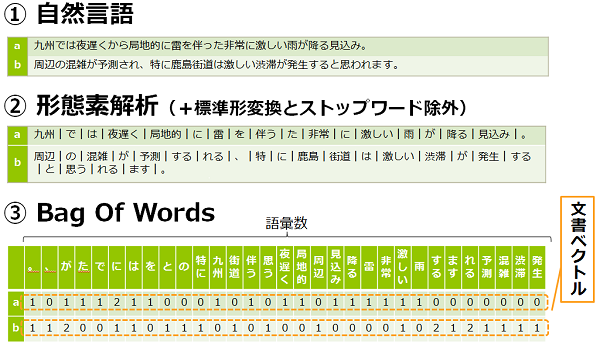

このように数値として扱えば、様々な計算が楽に実行できるようになります。

<br>

### 8.2.1　単語を特徴ベクトルに変換する

まず、文を3つ用意する。

In [4]:
docs = np.array([
    
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining, the weather is sweet, and one and one is two'

])

scikit-learnに実装されているCountVectorizer()で、BoWベクトルをカウントする。

In [5]:
count = CountVectorizer()
bag = count.fit_transform(docs)

上記のコードによって、次の3つの文章におけるBoWモデルが構築された。

ここで、各単語に番号（インデックス）を付け、それぞれ確認する。

In [6]:
print('単語:インデックス', count.vocabulary_)

単語:インデックス {'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


3文目の「the」の頻出度を調べてみる。<br>
0から数えるとインデックスは2となり、最後には単語を入れる。

In [7]:
print('頻出度：', bag.toarray()[2][count.vocabulary_['the']])

頻出度： 2


次に、特徴ベクトルを出力する。

In [8]:
pd.DataFrame(bag.toarray())

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,1,0,1,0,0
1,0,1,0,0,0,1,1,0,1
2,2,3,2,1,1,1,2,1,1


行は1～3文目、列は各単語のインデックス番号を前提に表示されている。

分かりやすいように、表示し直す。

In [9]:
pd.DataFrame(bag.toarray(), index=['1文目', '2文目', '3文目'],
             columns=['and', 'is', 'one', 'shining', 'sun', 'sweet', 'the', 'two', 'weather'])

,and,is,one,shining,sun,sweet,the,two,weather
1文目,0,1,0,1,1,0,1,0,0
2文目,0,1,0,0,0,1,1,0,1
3文目,2,3,2,1,1,1,2,1,1


<br>

### 8.2.2　TF-IDFを使って単語の関連性を評価する<br>

$\mathbf{TF}$：対象の単語が、ある文書中にどれだけの頻度で出現しているか（頻度）<br>
$\mathbf{IDF}$：対象の単語が含まれる文が、文章全体にどれだけの頻度で出現していないか（珍しさ）<br>
$\mathbf{TF-IDF}$：Term Frequency – Inverse Document Frequency の略（重みづけの指標）<br>
<br>

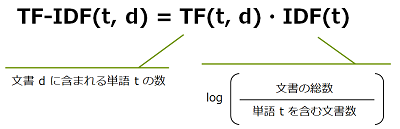

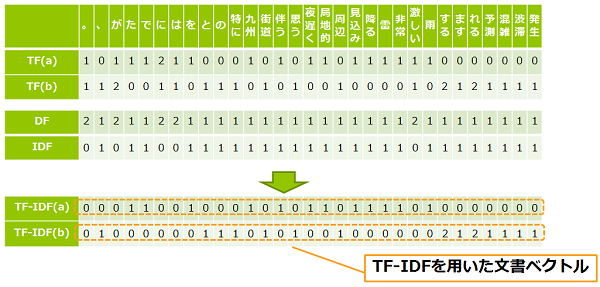

例えば、小説一冊が、下記で構成されているとする。

・$D$ 個の文<br>
・$N$ 個の単語

小説に単語 $x$ が $n$ 回現れるならば
$$\mathbf{TF}=\frac{n}{N}$$
小説に単語 $x$ を含む文が $d$ 個あるならば
$$\mathbf{IDF}=-log_{10}\frac{d}{D}=log_{10}\frac{D}{d}$$
よって、次のように求まる。
$$\mathbf{TF-IDF}=\frac{n}{N}log_{10}\frac{D}{d}$$

#### 例題

太宰治の作品「一歩前進二歩退却」から一部を抜粋しました。<br>
TF-IDFを求めなさい。

-----

　作家は、いよいよ窮屈である。何せ、眼光紙背に徹する読者ばかりを<br>
相手にしているのだから、うっかりできない。あんまり緊張して、ついには<br>
机のまえに端座したまま、そのまま、沈黙は金、という格言を底知れず肯定している。<br>
そんなあわれな作家さえ出て来ぬともかぎらない。<br>
　謙譲を、作家のみ要求し、作家は大いに恐縮し、卑屈なほどへりくだって<br>
そうして読者は旦那である。作家の私生活、底の底まで剥ごうとする。<br>
失敗である。安売りにしていいのは作品である。作家の人間までを売ってはいない。<br>
謙譲は、読者にこそ之を要求したい。

-----

下記をカウントしました。<br>
<br>
単語数 $N$：150<br>
単語の種類：48<br>
文数 $D$：10

次に「作家」という単語 $x$ に着目します。

出現回数 $n$：6<br>
含まれる文数 $d$：5

よって、次のように求まります。<br>
$$\mathbf{TF}=\frac{n}{N}=\frac{6}{150}=0.04$$<br>
$$\mathbf{IDF}=log_{10}\frac{D}{d}=log_{10}\frac{10}{5}=0.301$$<br>
$$\mathbf{TF-IDF}=0.0120$$<br>
実際の自然言語処理では、これを48種類の単語すべてに行っていきます。

### 8.2.3　scikit-learnで実装

scikit-learnにはTfidTransformerという変換器も実装されている。<br>
これは、fit_transformメソッドのCountVectorizerから「生の単語の出現頻度」を入力として受け取り、TF-IDFに変換する。

In [10]:
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
tfidf_vec = tfidf.fit_transform(count.fit_transform(docs)).toarray()

print(tfidf_vec.round(2))

[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


smooth_idf：Truleがデフォルト<br>
use_idf：idf()の使用有無（デフォルトではidf()関数による重み付けを行い、use_idf=Falseでidf()の計算を行わない）<br>
norm：正則化の指定（デフォルトでは正規化を行わず、norm='l2'を指定すると単語ベクトルの長さが1になるよう正規化）<br>
toarray()：行列出力

それぞれの文や単語とも紐づけて可視化してみる。

In [11]:
tfidf_df = pd.DataFrame(tfidf_vec.round(2), index=['1文目', '2文目', '3文目'],
             columns=['and', 'is', 'one', 'shining', 'sun', 'sweet', 'the', 'two', 'weather'])

tfidf_df

,and,is,one,shining,sun,sweet,the,two,weather
1文目,0.0,0.43,0.0,0.56,0.56,0.00,0.43,0.00,0.00
2文目,0.0,0.43,0.0,0.00,0.00,0.56,0.43,0.00,0.56
3文目,0.5,0.45,0.5,0.19,0.19,0.19,0.30,0.25,0.19


ここで、3つの文章を改めて見てみる。

●The sun is shining<br>
●The weather is sweet<br>
●The sun is shining, the weather is sweet, and one and one is two<br>

「is」は3つの文章で使われているため、特徴語ではなく、どの文法に必要な語と判断される。<br>
TF-IDFが（0.45）とそれほど大きくないことからも考えられる。

一方で、「one」は3つ目の文章だけで2回使用されているので<br>
TF-IDFは（0.5）と少しだけ大きくなっている。

### 8.2.4　scikit-learnでの定義式

また各々の特徴ベクトルのTF-IDFを「手動」で計算すると、上記の計算と合わないことが分かる。<br>
scikit-learnについて、厳密には下記の式で定義される。

$$\text{tf}(t,d)=N$$

$$\text{idf} (t,d) = log\frac{1 + n_d}{1 + \text{df}(d, t)}+1$$

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$

$N$：1つの文章の中にある、単語$t$の出現回数

TF-IDFの正規化については、次式のように定義される。<br>

$$v_{\text{norm}} = \frac{v}{||v||_2} = \frac{v}{\sqrt{v_{1}^{2} + v_{2}^{2} + \dots + v_{n}^{2}}} = \frac{v}{\big (\sum_{i=1}^{n} v_{i}^{2}\big)^\frac{1}{2}}$$

ここで、3つ目の文章について、改めて確認をする。

●The sun is shining, the weather is sweet, and one and one is two

今後は「is」に着目して、考えていくことにする。

#### scikit-learnの計算方法を手動で行う

TFについて、scikit-learnでは、単語「is」の出現回数がそのままの値となる。<br>
3つ目の文章において、「is」は3個あるため、次のようになる。

$$\text{tf}("is")= 3$$

IDFは定義式と同じままである。

$$\text{idf}("is", d3) = log \frac{1+3}{1+3}+1 = 0+1=1$$

よってTF-IDFは、次の値となる。

$$\text{tf-idf}("is",d3)= 3 \times 1 = 3$$

これらの計算を3つ目の文章の全ての単語に行った後で<br>
先ほど説明した正規化の式に従って、TF-IDFのL2正規化を行う。

$$\text{tf-idf}_{norm} = \frac{[3.39, 3.0, 3.39, 1.29, 1.29, 1.29, 2.0 , 1.69, 1.29]}{\sqrt{[3.39^2, 3.0^2, 3.39^2, 1.29^2, 1.29^2, 1.29^2, 2.0^2 , 1.69^2, 1.29^2]}}$$
<br>
<br>
$$=[0.5, 0.45, 0.5, 0.19, 0.19, 0.19, 0.3, 0.25, 0.19]$$
<br>
<br>
$$\Rightarrow \text{tf-idf}_{norm}("is", d3) = 0.45$$

In [12]:
print(tfidf_df.loc['3文目', 'is'])
tfidf_df

0.45


,and,is,one,shining,sun,sweet,the,two,weather
1文目,0.0,0.43,0.0,0.56,0.56,0.00,0.43,0.00,0.00
2文目,0.0,0.43,0.0,0.00,0.00,0.56,0.43,0.00,0.56
3文目,0.5,0.45,0.5,0.19,0.19,0.19,0.30,0.25,0.19


これにより、手動での計算結果とscikit-learnの計算結果の一致が証明できました。<br>
自然言語処理では、このTF・IDF・TF-IDFをもとに、特徴ベクトル（特徴語、重み）を決定しています。

<br>

## 8.2.3　テキストデータのクレンジング

改めて、自然言語処理の説明について説明する。
<br>

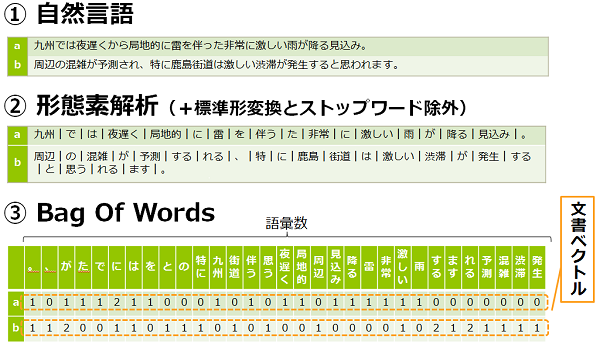

②において、例えばキーワードとは関係のない「で」「は」「に」「する」「と」など、不要な文字を含んでしまっている。<br>
これらの文字が入ったまま、TF-IDFによる特徴ベクトルの決定（重みづけ）をしても、正確な結果が得られなくなってしまう。<br>
そこでテキストデータを **クレンジング（ストップワードの除去）** を行う必要がある。

この重要性を理解するために、具体例を挙げて説明していく。<br>
まず、映画レビューデータセットの1つ目の文章から、最後の50文字を出力する。

In [13]:
df.loc[0, 'review'][-50:]

'is seven.<br /><br />Title (Brazil): Not Available'

出力結果を見てみると、不要な句読点や非英字文字が多い。<br>
感情分析に役に立ちそうな顔文字要素のある記号「　：)　」のみ残し、それ以外はすべて削除する。<br>
その際、今回はPythonの正規表現ライブラリを使用する。

In [14]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

re.sub：正規表現で指定した文字列を置換する<br>
str.lower(): すべての文字を小文字に変換

2行目で正規表現（<[^>]*>）を使用することで、HTMLマークアップを完全に削除する。<br>
3行目で顔文字を検索し、emoticonsに格納している。<br>
4行目で正規表現[\w]+を使って単語の一部ではない文字を削除し、小文字に変換したのち、emoticonsを加え、顔文字内の「-」を消去している。

In [15]:
print('変換前:', df.loc[0, 'review'][-50:])
print('変換後:', preprocessor(df.loc[0, 'review'][-50:]))

変換前: is seven.<br /><br />Title (Brazil): Not Available
変換後: is seven title brazil not available


In [16]:
print(preprocessor("</a>This :) is :( a test :-)!"))
print(preprocessor("!\/.i like ;.::python/:]/];/]"))
print(preprocessor('machine\::lear\[:::nig];@[/]'))

this is a test :) :( :)
 i like python 
machine lear nig 


再度、映画レビューデータセットの1行目を表示する。

In [17]:
df.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve...",1
1,OK... so... I really like Kris Kristofferson and his usual easy going delivery of lines in his movies. Age has helped him with his soft spoken low...,0
2,"***SPOILER*** Do not read this, if you think about watching that movie, although it would be a waste of time. (By the way: The plot is so predicta...",0
3,hi for all the people who have seen this wonderful movie im sure thet you would have liked it as much as i. i love the songs once you have seen th...,1
4,"I recently bought the DVD, forgetting just how much I hated the movie version of ""A Chorus Line."" Every change the director Attenborough made to t...",0
5,Leave it to Braik to put on a good show. Finally he and Zorak are living their own lives outside of Spac Ghost Coast To Coast. I have to say that ...,1
6,"Nathan Detroit (Frank Sinatra) is the manager of the New York's longest- established floating craps game, and he needs $1000 to secure a new locat...",1
7,"To understand ""Crash Course"" in the right context, you must understand the 80's in TV. Most TV shows didn't have any point. The sitcom outpopulate...",1
8,"I've been impressed with Chavez's stance against globalisation for sometime now, but it wasn't until I saw the film at the Amsterdam documentary i...",1
9,This movie is directed by Renny Harlin the finnish miracle. Stallone is Gabe Walker. Cat and Mouse on the mountains with ruthless terrorists. Renn...,1


これに、先ほど作成したpreprocessor関数を適用する。<br>
出力結果を確認すると、余計な文字や記号がなくなっていることが分かる。

In [18]:
df['review'] = df['review'].apply(preprocessor)
df.head(10)

,review,sentiment
0,in 1974 the teenager martha moxley maggie grace moves to the high class area of belle haven greenwich connecticut on the mischief night eve of hal...,1
1,ok so i really like kris kristofferson and his usual easy going delivery of lines in his movies age has helped him with his soft spoken low energy...,0
2,spoiler do not read this if you think about watching that movie although it would be a waste of time by the way the plot is so predictable that i...,0
3,hi for all the people who have seen this wonderful movie im sure thet you would have liked it as much as i i love the songs once you have seen the...,1
4,i recently bought the dvd forgetting just how much i hated the movie version of a chorus line every change the director attenborough made to the s...,0
5,leave it to braik to put on a good show finally he and zorak are living their own lives outside of spac ghost coast to coast i have to say that i ...,1
6,nathan detroit frank sinatra is the manager of the new york s longest established floating craps game and he needs 1000 to secure a new location c...,1
7,to understand crash course in the right context you must understand the 80 s in tv most tv shows didn t have any point the sitcom outpopulated the...,1
8,i ve been impressed with chavez s stance against globalisation for sometime now but it wasn t until i saw the film at the amsterdam documentary in...,1
9,this movie is directed by renny harlin the finnish miracle stallone is gabe walker cat and mouse on the mountains with ruthless terrorists renny h...,1


<br>

## 8.2.4　文書をトークン化する

トークン化：文章を個々の単語に分割したり、変換したりすること<br>
ワードステミング：単語を原形に変換すること　（例）running →　run　など

ワードステミングは、PorterStemmerによって最初に開発されたので、Porter stemmingアルゴリズムとも呼ばれる。<br>
NLTKライブラリに実装されている。

In [19]:
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

split()：文字を空白で分割<br>
tokenizer_porter(text)：split()で分割した単語をfor文で1個ずつ取り出し、ワードステミングを実行

ここで、トークン化とトークン化＋ワードワードステミングの結果を比較する。

In [20]:
print(tokenizer('runners like running and thus they run'))
print(tokenizer_porter('runners like running and thus they run'))

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']
['runner', 'like', 'run', 'and', 'thu', 'they', 'run']


また、8.2.3で説明したストップワードの除去も行う。<br>
こちらも、NLTKライブラリで実行することができる。

まず、nltkに登録されているストップワードをダウンロードする。<br>
その後、ストップワードでないものにtokenizer_porter()を適用し、単語wを抽出する。

In [21]:
nltk.download('stopwords')

stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and runs a lot')[-10:] if w not in stop]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['runner', 'like', 'run', 'run', 'lot']

<br>

## 8.2.5　文書を分類するロジスティック回帰モデルのトレーニング

ロジスティック回帰を用いて、下記に分類する。

1：肯定的なレビュー（面白かった など）<br>
2：否定的なレビュー（つまなかった など）

まず、クレンジングしたテキストのDataframeを、訓練データとテストデータに分割する。

In [22]:
print(df.shape)
df.head()

(50000, 2)


,review,sentiment
0,in 1974 the teenager martha moxley maggie grace moves to the high class area of belle haven greenwich connecticut on the mischief night eve of hal...,1
1,ok so i really like kris kristofferson and his usual easy going delivery of lines in his movies age has helped him with his soft spoken low energy...,0
2,spoiler do not read this if you think about watching that movie although it would be a waste of time by the way the plot is so predictable that i...,0
3,hi for all the people who have seen this wonderful movie im sure thet you would have liked it as much as i i love the songs once you have seen the...,1
4,i recently bought the dvd forgetting just how much i hated the movie version of a chorus line every change the director attenborough made to the s...,0


In [23]:
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

次に、GridSearchCVを使ってロジスティック回帰モデルの最適なパラメーター集合を求める。<br>
ここでは、5分割交差検証を使用する。

In [24]:
param_grid = [
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
    
              ]

Pipelineで、TfidfVectorizer()とLogisticRegression()をセットにする。

In [25]:
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)
logreg = LogisticRegression(random_state=0)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', logreg)])

In [26]:
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

scoring：評価指標名または評価関数（初期値はNone、分類はF1値・正解率、回帰はMSE　など）<br>
verbose：途中経過を詳細に出力（初期値はTrue）<br>
n_jobs：並列実行数（初期値は1）

In [27]:
if 'TRAVIS' in os.environ:
    gs_lr_tfidf.verbose=2

    X_train = df.loc[:250, 'review'].values
    y_train = df.loc[:250, 'sentiment'].values
    X_test = df.loc[25000:25250, 'review'].values
    y_test = df.loc[25000:25250, 'sentiment'].values

verbose: 0は標準出力にログを出力しない、1はログをプログレスバーで標準出力，2はエポックごとに1行のログを出力する

In [28]:
%%time

gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 151.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 194.5min finished


Wall time: 3h 14min 41s


C:\Users\Owner\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=0))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0, 100.0],
                          'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd",...
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
           

グリッドサーチが完了した後、性能指標が最も高くなるパラメータセットを出力する。

In [29]:
print('Best parameter set: %s '.format(gs_lr_tfidf.best_params_))
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: %s 
CV Accuracy: 0.897


このことから「C=10のときに、ロジスティック回帰とTF-IDFを組み合わせることで、性能指標が最も高くなる」ことが分かった。

また、余談だが「format」の代わりに「%」を使用することができる。

In [30]:
clf = gs_lr_tfidf.best_estimator_

y_pred = clf.predict(X_test)

print(y_pred[:10])

[0 1 1 0 0 1 0 1 1 0]


In [31]:
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.899


今回作成した機械学習モデルでは、映画レビューのデータセットを投入したときに<br>
各レビューが肯定的か否定的なのかを、約90%で正しく予測できることが分かった。

## 結論・考察

自然言語特有の前処理と分類モデルを組み合わせることで、実際のレビューや文字列を含むデータセットを扱うことができた。

ただし、今回はグリッドサーチを採用したため、パラメータ調整にとても時間がかかった。<br>
時間よりも精度にこだわる場合にはそれでも良いが、状況に応じてoptunaやランダムサーチも検討すべきである。

またパラメータ調整さえ上手くいけば、分類モデルではXBoostの方が精度が高い傾向にあるので、こちらも試してみたい。<br>
そして現場での実務等、あまり時間をかけずにモデリングを行いたい場合には、LightGBMなども導入してみると良い。